## Hello everybody 😃 😃 welcome back


In [19]:
import os
import cv2 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Image Size
IMG_ROWS, IMG_COLS = 100, 100 # input image dimensions
NB_CLASSES =  10 # number of outputs = number of digits

## (01)   ACQUISITION DES DONNEES - IMAGES DES FEUILLES DES PLANTES. 

In [20]:
########################################### function for plotting images

def plot_images(images, total_images=100, rows=20, cols=5, fsize=(20,100), titre='Image'):
    
    fig = plt.figure(figsize=fsize) # create a new figure window
    
    for i in range(total_images): # display images
        # subplot : 33 rows and 5 columns
        img_grid = fig.add_subplot(rows, cols, i+1)
        # plot features as image
        img_grid.imshow(images[i])
        
        plt.title(titre)


In [21]:
############################################ function for resizng images
       
def preprocess_image(image, image_height=IMG_ROWS, image_width=IMG_COLS):

    return cv2.resize(image, (image_height, image_width))

############################################ function for reading images 
       
def read_images (path , sz= None ):
    
    print('\nCHARGEMENT DES IMAGES DE LA BASE .......................!\n') 

    X,y = [], []
    
    for dirname , dirnames , filenames in os.walk(path):
        
        c = 0
        
        for subdirname in dirnames :
            
            subject_path = os. path . join ( dirname , subdirname )
            
            for filename in os. listdir ( subject_path ):
                
                im = Image.open(os.path.join(subject_path, filename))
                #im = im.convert ("L")

                if (sz is not None ):
                    im = im.resize (sz , Image.ANTIALIAS ) 
                    
                im = np.array(im)
                im = preprocess_image(im, IMG_ROWS, IMG_COLS)
                X.append(im)
                y.append (c)  
                
            c = c+1
            
    return [X,y]




LECTURE DES IMAGES DE LA BASE D'APPRENTISSAGE........!

CHARGEMENT DES IMAGES DE LA BASE .......................!


AFFICHAGE DE QUELQUES IMAGES DE LA BASE.................!


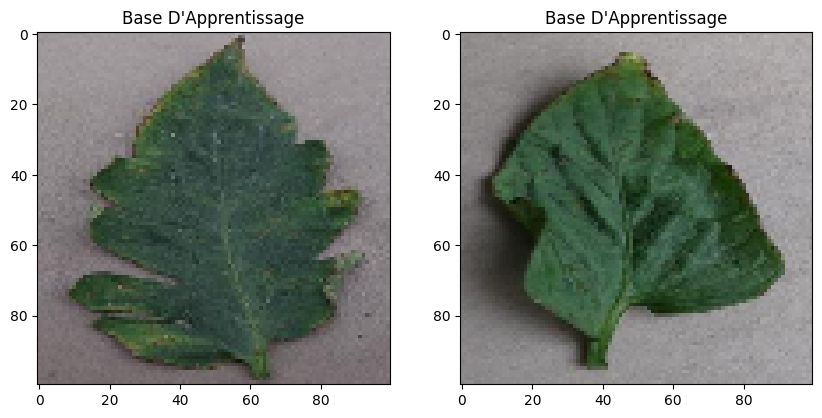


FIN D'AFFICHAGE DES IMAGES DE LA BASE...................!



In [22]:
############################################ Read And Resize test images

print('\n\nLECTURE DES IMAGES DE LA BASE D\'APPRENTISSAGE........!') 

[X_train, y_train] = read_images("C:/Users/Dell 7280/Documents/Etude/ESCEP/S3/Deep learning/Corrections/TP4-Tomato/Data/TrainData") # Tomato

print('\nAFFICHAGE DE QUELQUES IMAGES DE LA BASE.................!')
plot_images(X_train, 2, 1, 2,(10, 50), titre='Base D\'Apprentissage')
plt.show()
print('\nFIN D\'AFFICHAGE DES IMAGES DE LA BASE...................!\n')

In [23]:
############################################################# Train Data

images_train = X_train
images_train = np.asarray(images_train)

# Train targets
train_features = images_train
train_targets = y_train

from keras.utils import to_categorical
# convert class vectors to binary class matrices
train_targets = to_categorical(train_targets, NB_CLASSES)

print('\nNORMALISATION DES BASES DE TEST ET D\'APPRENTISSAGE.\n')

########################################################## Normalisation

train_features = train_features.astype('float32')

mean_vals = np.mean(train_features, axis=0)
std_val = np.std(train_features)
train_features = (train_features - mean_vals)/std_val

train_features = train_features.reshape(train_features.shape[0], IMG_ROWS, IMG_COLS, 3)
print("train_features.shape     >==============<> : {}".format(train_features.shape))
print("train_targets.shape      >==============<> : {}".format(train_targets.shape))


NORMALISATION DES BASES DE TEST ET D'APPRENTISSAGE.

train_features.shape     >==============<> : (7416, 100, 100, 3)
train_targets.shape      >==============<> : (7416, 10)


In [24]:
########################################################################
#(02)        CLASSIFICATION : CREATION DU MODELE DE PREDICTION         #
########################################################################

In [25]:
from keras import optimizers
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers import AveragePooling2D, GlobalAveragePooling2D
from keras.layers import concatenate
from keras.applications import DenseNet121
from keras.optimizers import Adam
from keras.layers import Dense, Flatten
from keras import backend as K
import time

In [26]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D, Dense, MaxPooling2D, concatenate
from tensorflow.keras.models import Model

def dense_block(x, blocks, name):
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x

def transition_block(x, reduction, name):
    x = BatchNormalization(axis=-1, epsilon=1.001e-5, name=name + '_bn')(x)
    x = Activation('relu', name=name + '_relu')(x)
    x = Conv2D(int(x.shape[-1] * reduction), 1, use_bias=False, name=name + '_conv')(x)
    x = AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x

def conv_block(x, growth_rate, name):
    x1 = BatchNormalization(axis=-1, epsilon=1.001e-5, name=name + '_0_bn')(x)
    x1 = Activation('relu', name=name + '_0_relu')(x1)
    x1 = Conv2D(4 * growth_rate, 1, use_bias=False, name=name + '_1_conv')(x1)
    x1 = BatchNormalization(axis=-1, epsilon=1.001e-5, name=name + '_1_bn')(x1)
    x1 = Activation('relu', name=name + '_1_relu')(x1)
    x1 = Conv2D(growth_rate, 3, padding='same', use_bias=False, name=name + '_2_conv')(x1)
    x = concatenate([x, x1], axis=-1, name=name + '_concat')
    return x

def DenseNet(input_shape, classes):
    img_input = Input(shape=input_shape)
    x = Conv2D(64, 7, strides=2, use_bias=False, padding='same', name='conv1/conv')(img_input)
    x = BatchNormalization(axis=-1, epsilon=1.001e-5, name='conv1/bn')(x)
    x = Activation('relu', name='conv1/relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same', name='pool1')(x)

    x = dense_block(x, blocks=6, name='conv2')
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, blocks=12, name='conv3')
    x = transition_block(x, 0.5, name='pool3')
    x = dense_block(x, blocks=24, name='conv4')
    x = transition_block(x, 0.5, name='pool4')
    x = dense_block(x, blocks=16, name='conv5')

    x = BatchNormalization(axis=-1, epsilon=1.001e-5, name='bn')(x)
    x = Activation('relu', name='relu')(x)
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(classes, activation='softmax', name='fc')(x)

    model = Model(inputs=img_input, outputs=x, name='densenet')
    return model


In [27]:
# Définition de l'optimiseur et des paramètres
OPTIMIZER = Adam()
IMG_ROWS, IMG_COLS = 64, 64  # Mettez les dimensions correctes de vos images ici
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 3)
NB_CLASSES = 1000  # Changez ceci selon votre nombre de classes
NB_EPOCH = 50
BATCH_SIZE = 64
VERBOSE = 1

# Redimensionnement des données d'entrée
def resize_images(images, target_size):
    resized_images = np.zeros((images.shape[0], *target_size, 3))
    for i, img in enumerate(images):
        resized_images[i] = np.resize(img, (*target_size, 3))
    return resized_images

# Charger et redimensionner les images d'entraînement
train_features = resize_images(np.asarray(X_train), (IMG_ROWS, IMG_COLS))

# Convertir les étiquettes en matrices de classe binaires
train_targets = to_categorical(np.asarray(y_train), NB_CLASSES)

print('\nNORMALISATION DES BASES DE TEST ET D\'APPRENTISSAGE.\n')

# Normalisation des données
train_features = train_features.astype('float32')
mean_vals = np.mean(train_features, axis=0)
std_val = np.std(train_features)
train_features = (train_features - mean_vals) / std_val

# Vérifiez les dimensions des données
print("train_features.shape     >==============<> : {}".format(train_features.shape))
print("train_targets.shape      >==============<> : {}".format(train_targets.shape))

def build_densenet(input_shape, classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=2, strides=2, padding='same')(x)
    # Ajoutez les couches supplémentaires pour votre modèle ResNet ici

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Construction et compilation du modèle ResNet
model = build_densenet(input_shape=INPUT_SHAPE, classes=NB_CLASSES)
model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=['accuracy'])

# Affichage du résumé du modèle
model.summary()

# Enregistrement du temps de début d'entraînement
t_start = time.time()

# Entraînement du modèle
history = model.fit(train_features, train_targets, batch_size=BATCH_SIZE, epochs=NB_EPOCH, verbose=VERBOSE)

# Calcul du temps total d'entraînement
time_full_train = time.time() - t_start

# Affichage du temps d'entraînement
print("\nTEMPS D'APPRENTISSAGE DU CLASSIFIEUR >====<> : %0.2fs " % (time_full_train))

# Sauvegarde du modèle entraîné
model.save("DenseNet_groupe_2.h5")
print('\nENREGISTRER LE MODELE .\n')



NORMALISATION DES BASES DE TEST ET D'APPRENTISSAGE.

train_features.shape     >==============<> : (7416, 64, 64, 3)
train_targets.shape      >==============<> : (7416, 1000)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 16, 16, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │        65,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,728 (291.91 KB)

 Trainable params: 74,600 (291.41 KB)

 Non-trainable params: 128 (512.00 B)

116/116 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.2109 - loss: 5.3625



TEMPS D'APPRENTISSAGE DU CLASSIFIEUR >====<> : 19.30s 

ENREGISTRER LE MODELE .



Membre du groupe N°2:


ISSA IBRAHIM Moubarak

Abdourahamen bachir